SNR Measurement for Field Strength Comparisons
===============================================

This notebook is a self contained workflow for analyzing relaxation and SNR measurements. 

Change plotting settings here for outer types of output (e.g. `inline`)

In [1]:
%matplotlib notebook

Functions for labeling and analyzing images

In [3]:
import os
import dicom

import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, moments
from skimage.morphology import closing, erosion, square
from scipy.signal import medfilt
from scipy.optimize import fmin

def display_dicom(dcm,colormap='gray',colorbar=True):
    fig, ax = plt.subplots(ncols=1, nrows=1)
    cax = ax.imshow(dcm.pixel_array,cmap=plt.get_cmap(colormap))

    if colorbar:
        fig.colorbar(cax)

def parse_dicom_tree(path):
    dcms = dict()
    for fn in os.listdir(path):
        ffn = os.path.join(path,fn)
        if os.path.isfile(ffn):
            try:
                ds = dicom.read_file(ffn)
                snum = ds.SeriesNumber
                if not snum in dcms:
                    dcms[snum] = list()
                dcms[snum].append(ds)
                
            except dicom.errors.InvalidDicomError:
                print("Skipping " + ffn + ", not a DICOM file")
    return dcms

def print_dicom_summary(dcms):
    series = sorted(dcms.keys())
    for s in series:
        print (str(dcms[s][0].SeriesNumber) + '\t' + str(len(dcms[s])) + '\t' + dcms[s][0].SeriesDescription)
        
def label_image(image, threshold_sensitivity=0.1,erosion_size=4):
    # apply threshold
    thresh = threshold_otsu(image)
    bw = closing(image > threshold_sensitivity*thresh, square(3))
    bw = erosion(bw, square(erosion_size))

    # remove artifacts connected to image border
    cleared = bw.copy()
    clear_border(cleared)

    # label image regions
    label_image = label(cleared)
    borders = np.logical_xor(bw, cleared)
    label_image[borders] = 0
    
    return label_image

def display_labels(label_image):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(label_image,cmap=plt.cm.gray)

    for l in range(1,np.max(label_image)+1):
        ml = (label_image == l)
        m = moments(ml.astype(np.double))
        c = m[0, 1] / m[0, 0], m[1, 0] / m[0, 0]
        ax.text(c[1], c[0],str(l),color='red')
        
def calc_flip_angle_map(dcm1,dcm2):
    if dcm1.FlipAngle > dcm2.FlipAngle:
        im_low = dcm2.pixel_array
        im_high = dcm1.pixel_array
        flip_angle_low = dcm2.FlipAngle
        flip_angle_high = dcm1.FlipAngle
    else:
        im_low = dcm1.pixel_array
        im_high = dcm2.pixel_array
        flip_angle_low = dcm1.FlipAngle
        flip_angle_high = dcm2.FlipAngle

    if flip_angle_high != 2*flip_angle_low:
        raise Exception('Low flip angle is not half of high flip angle')
    
    im_low = medfilt(im_low.astype(np.double),5)
    im_high = medfilt(im_high.astype(np.double),5)

    q = im_high/(2*(im_low+np.finfo(np.double).eps))
    q = np.clip(q,-1, 1);
    fa = np.arccos(q)*(180/np.pi);    
    
    #q = im_low/(im_high+np.finfo(np.double).eps)
    #q = np.clip(q,-1, 1);
    #fa = np.arcsin(q)*(180/np.pi);    

    fa = fa/flip_angle_low
    return fa

def get_label_mean(img,label_image,labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)
    
    means = list()
    for l in labels:
        m = (label_image == l).astype(np.double)
        s = np.sum(m*img)/np.sum(m)
        means.append(s)
        
    return means

def get_IR_data(dcms, label_image, labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)

    images = len(dcms)
    labs = len(labels)

    TIs = np.zeros((images,),dtype=np.double)
    signal = np.zeros((images,labs),dtype=np.double)

    for idx, im in enumerate(dcms):
        means = get_label_mean(im.pixel_array,label_image,labels=labels)
        signal[idx,:] = np.array(means)
        TIs[idx] = im.InversionTime
        
    idx = [i[0] for i in sorted(enumerate(TIs), key=lambda x:x[1])]  
    signal = signal[idx,:]
    TIs = TIs[idx]
    
    return TIs, signal

def fit_t1_mag_IR(TIs, IRSignal):
    #Doing 3 parameters fit
    # S = A - B exp(-TI./T1star)
    
    if len(IRSignal.shape) > 1:
        curves = IRSignal.shape[1]
    else:
        curves = 1
    
    fits = list()
    for c in range(0,curves):
        #First get a starting estimate
        s = IRSignal[:,c]
        ss = sorted(enumerate(abs(s)), key=lambda x: x[1])
        if ss[0][0] == 0: 
            T1star = np.min(TIs)/np.log(2);
        else:
            tmp = ss[0:2]
            if tmp[0][0] > tmp[1][0]:
                tmp = [tmp[1], tmp[0]]
            slope = (tmp[1][1] + tmp[0][1])/(TIs[tmp[1][0]]-TIs[tmp[0][0]])
            T1star = (tmp[0][1]/slope + TIs[tmp[0][0]])/np.log(2)
        

        #Next let's do the fit with scipy.optimize.fmin (simplex)
        Ainit = np.max(np.abs(s))
        x0 = [Ainit, 2*Ainit, T1star] 
        costfcn = lambda x: np.sum((np.abs(x[0]-x[1]*np.exp(-TIs/x[2]))-s)**2)
        x = fmin(costfcn,x0=x0,disp=False)
        fits.append(x)
        
    return fits

def get_SE_data(dcms, label_image, labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)

    images = len(dcms)
    labs = len(labels)

    TEs = np.zeros((images,),dtype=np.double)
    signal = np.zeros((images,labs),dtype=np.double)

    for idx, im in enumerate(dcms):
        means = get_label_mean(im.pixel_array,label_image,labels=labels)
        signal[idx,:] = np.array(means)
        TEs[idx] = im.EchoTime
        
    idx = [i[0] for i in sorted(enumerate(TEs), key=lambda x:x[1])]  
    signal = signal[idx,:]
    TEs = TEs[idx]
    
    return TEs, signal

def fit_t2_SE(TEs,signal):
    #Doing s parameters fit
    # S = A exp(-TE./T2)
    
    if len(IRSignal.shape) > 1:
        curves = IRSignal.shape[1]
    else:
        curves = 1
    
    fits = list()
    for c in range(0,curves):
        #First get a starting estimate
        s = signal[:,c]
        y = np.log(np.abs(s))
        x = TEs;
        b = np.sum((x - np.mean(x))*(y - np.mean(y)))/np.sum((x - np.mean(x))**2)
        a = np.mean(y) - b*np.mean(x)
        x0 = [np.exp(a), -1/b]

        costfcn = lambda x: np.sum((np.abs(x[0]*np.exp(-TEs/x[1]))-s)**2)
        x = fmin(costfcn,x0=x0,disp=False)
        fits.append(x)
    return fits

def imlist_to_pixel_array(imgs):
    img_size = imgs[0].pixel_array.shape
    img_array = np.zeros((len(imgs), img_size[0],img_size[1]))
    for idx, i in enumerate(imgs):
        img_array[idx,:,:] = i.pixel_array
    return img_array

Reading Images
===============

The analysis workflow starts with parsing all the dicom images in a given folder. The list below should give an overview of serries names and the number of images in each series.  

In [4]:
d = parse_dicom_tree('/home/hansenms/data/deuterium20161121')
print_dicom_summary(d)

1	60	gre_localizer_qbody
2	4	BH_FW_CV_me_724_4e
3	1	BH_FW_CV_me_724_4e_Water
4	1	BH_FW_CV_me_724_4e_Fat
5	1	BH_FW_CV_me_724_4e_FreqMap
6	1	BH_FW_CV_me_724_4e_T2starMap
7	11	SASHA_10pt_TS600_256
8	1	SASHA_10pt_TS600_256_ERR
9	1	SASHA_10pt_TS600_256_T1
10	8	BH_gt_T2star_DB_8e_256__GT_AVE
11	1	BH_gt_T2star_DB_8e_256__GT_AVE_T2STAR
12	1	BH_gt_T2star_DB_8e_256__GT_AVE_R2STAR
13	1	BH_gt_T2star_DB_8e_256__GT_AVE_T2SMASKMAP
14	100	CV_BODY
15	100	CV_SURFACE
16	100	GRE_BODY
17	100	GRE_SURFACE
18	1	MiniFLASH_b1_map_35__GT
19	1	MiniFLASH_b1_map_35__GT_SNR_MAP
20	1	MiniFLASH_b1_map_35__GT_Noise_SD_Plot
21	1	MiniFLASH_b1_map_70__GT
22	1	MiniFLASH_b1_map_70__GT_SNR_MAP
23	1	MiniFLASH_b1_map_70__GT_Noise_SD_Plot
24	1	se_msh_TE10
25	1	se_msh_TE20
26	1	se_msh_TE30
27	1	se_msh_TE60
28	1	se_msh_TE120
29	1	se_msh_TE200
30	1	se_msh_TE320
31	1	IR_MiniFLASH TI10__GT
32	1	IR_MiniFLASH TI10__GT_SNR_MAP
33	1	IR_MiniFLASH TI10__GT_Noise_SD_Plot
34	1	IR_MiniFLASH TI30__GT
35	1	IR_MiniFLASH TI30__GT_SNR_MAP
36	1	IR

Classification of Image Series
===============================

Based on the list above, identify 

In [5]:
fa_data = [18,21] #flip angle measurements
IR_data = [31,34,37,40,43,46,49,52,55] #Inversion Recovery (T1) data
SE_data = [69,72,75,78,81,84,87] #Spin Echo (T2) data
T2star_data = [11] #T2* data
SSFP_data = [59] #SSFP images (multiple reps)
GRE_data = [16] #GRE images (multiple reps)

<IPython.core.display.Javascript object>


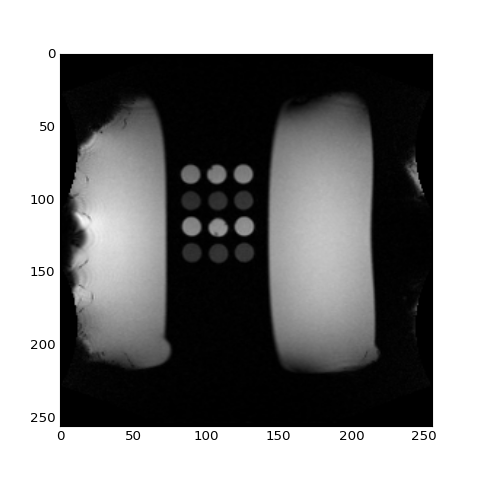

In [6]:
# Initial overview image
im = d[fa_data[0]][0]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(im.pixel_array,cmap=plt.cm.gray)

<IPython.core.display.Javascript object>


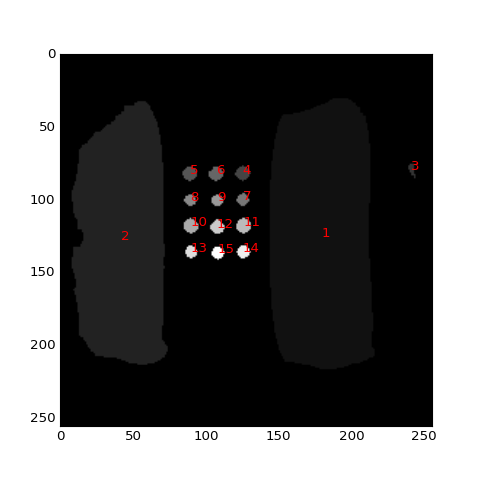

In [7]:
#Now label the data
im = d[fa_data[0]][0]
labels = label_image(im.pixel_array,threshold_sensitivity=0.5)
display_labels(labels)

Regions of Interest
====================

Based on automatic labeling above, select the tubes (phantoms) you are interested in analyzing

In [8]:
tubes = [5,6,4,8,9,7,10,12,11,13,15,14]
lf_tubes = [3,4,5,9,10,11]
hf_tubes = [0,1,2,6,7,8]

<IPython.core.display.Javascript object>


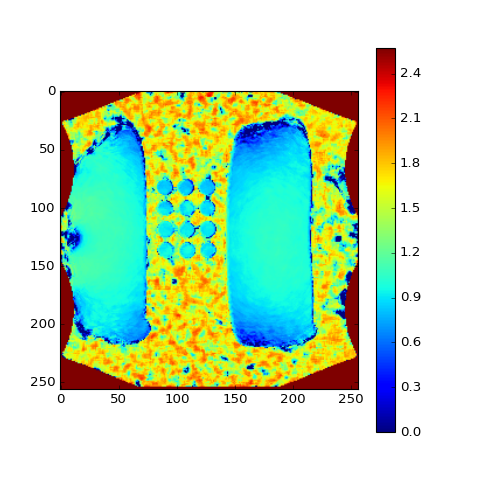

In [9]:
# Flip angle map
fa = calc_flip_angle_map(d[fa_data[0]][0],d[fa_data[1]][0])
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
img = ax.imshow(fa,cmap=plt.cm.jet)
fig.colorbar(img)

<IPython.core.display.Javascript object>


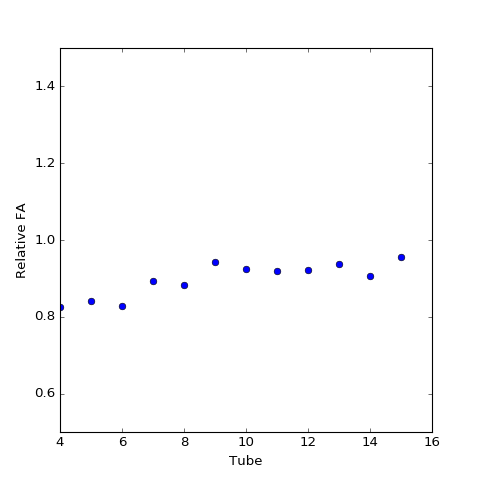

In [10]:
#Flip angles in tubes
rel_fa = get_label_mean(fa,labels,labels=tubes)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.plot(tubes,rel_fa,'o')
ax.set_ylim([0.5,1.5])
ax.set_xlabel('Tube')
ax.set_ylabel('Relative FA')

<IPython.core.display.Javascript object>


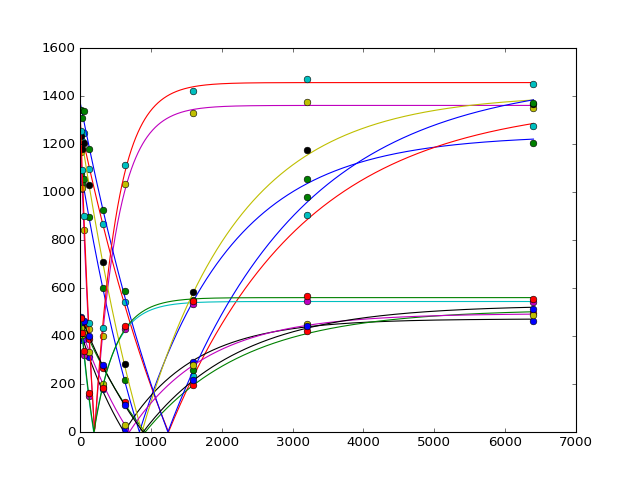

In [11]:
# Estimate T1
dcms = [d[i][0] for i in IR_data]

TIs, IRSignal = get_IR_data(dcms, labels, tubes)
fits_t1 = fit_t1_mag_IR(TIs,IRSignal)

fig, ax = plt.subplots(ncols=1, nrows=1)
line_vals = np.linspace(0,np.max(TIs),1000)
for t in range(0,len(tubes)):
    _ = ax.plot(line_vals,np.abs(fits_t1[t][0]-fits_t1[t][1]*np.exp(-line_vals/fits_t1[t][2])),'-')
    _ = ax.plot(TIs,IRSignal[:,t],'o')


In [12]:
# Print T1 values
[x[2] for x in fits_t1]

[1308.7651037054989,
 1901.6332645066043,
 316.41203194106015,
 973.905613423369,
 1411.8847054791881,
 294.63886450312992,
 1360.8603904543138,
 1886.3086807294114,
 313.89477211187966,
 1090.1519153551144,
 1358.1768543362314,
 302.34408281862977]

<IPython.core.display.Javascript object>


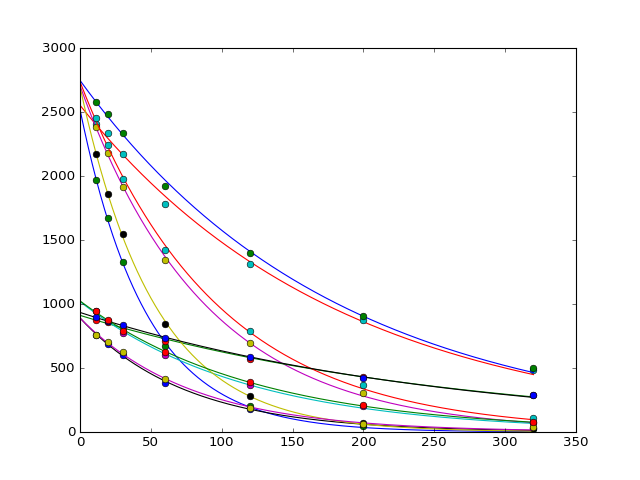

In [13]:
# Estimate T2
TEs, SESignal = get_SE_data([d[i][0] for i in SE_data],labels,tubes)
fits_t2 = fit_t2_SE(TEs,SESignal)

fig, ax = plt.subplots(ncols=1, nrows=1)
line_vals = np.linspace(0,np.max(TEs),1000)
for t in range(0,len(tubes)):
    _ = ax.plot(line_vals,fits_t2[t][0]*np.exp(-line_vals/fits_t2[t][1]),'-')
    _ = ax.plot(TEs,SESignal[:,t],'o')

In [14]:
# Print T2 values
[x[1] for x in fits_t2]

[46.778089225848994,
 183.99058068839037,
 88.233246355782967,
 74.398005212883163,
 266.22291472516031,
 117.38038696026064,
 52.828319617114879,
 179.95768091585154,
 95.483921427682361,
 79.228973821811564,
 257.92983359128453,
 123.39928236307333]

In [15]:
# T2* values
t2star_img = d[T2star_data[0]][0].pixel_array
T2stars = get_label_mean(t2star_img,labels,tubes)
T2stars = np.array(T2stars)/10.0
T2stars

array([  38.69594595,  118.54657534,   64.91756757,   64.27959184,
        154.36734694,   86.93518519,   46.68076923,  120.92028986,
         70.07160494,   68.60740741,  156.96842105,   92.29180328])

In [16]:
# Estiimate M0
echo_time_im = 0
T1s = np.array([x[2] for x in fits_t1],dtype=np.double)
T2s = np.array([x[1] for x in fits_t2],dtype=np.double)
TR  = d[SE_data[1]][0].RepetitionTime
TE  = d[SE_data[1]][0].EchoTime
M0s = np.squeeze(SESignal[1,:])/((1-np.exp(-TR/T1s))*(np.exp(-TE/T2s)))
M0s = M0s/rel_fa

In [17]:
# Print M0
M0s

array([ 3052.57941862,  3161.77094019,  3311.28891403,  1023.69483451,
         980.9029068 ,  1146.66791449,  2943.92586555,  3029.03403121,
        3003.88368862,   963.30768163,   983.40226965,  1130.56376532])

In [18]:
# M0 using the model fit
np.asarray([x[0] for x in fits_t2])/rel_fa

array([ 2996.8852975 ,  3086.58420047,  3275.67738026,  1009.57636436,
         967.85609798,  1140.92418078,  2921.50186596,  2980.66171809,
        2976.62592332,   950.72102784,   977.14114114,  1129.10476789])

<IPython.core.display.Javascript object>


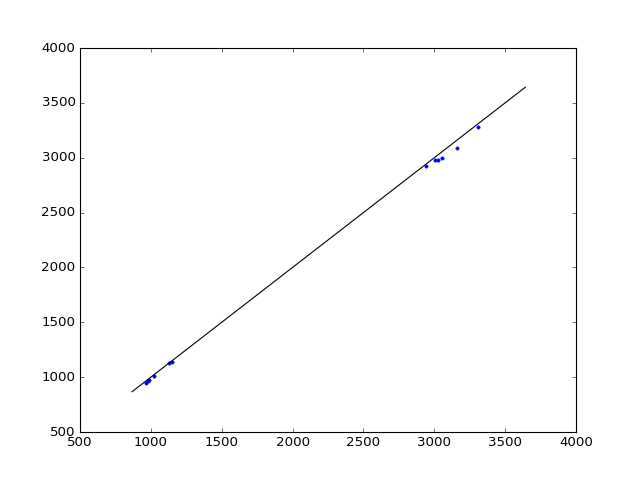

In [19]:
M0s_t2fit = np.asarray([x[0] for x in fits_t2])/rel_fa
M0s_t1fit = np.asarray([x[0] for x in fits_t1])/rel_fa
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.plot(M0s,M0s_t2fit,'.b')
identity = np.linspace(np.min(M0s)*0.9,np.max(M0s)*1.1,100)
ax.plot(identity,identity,'-k')

<IPython.core.display.Javascript object>


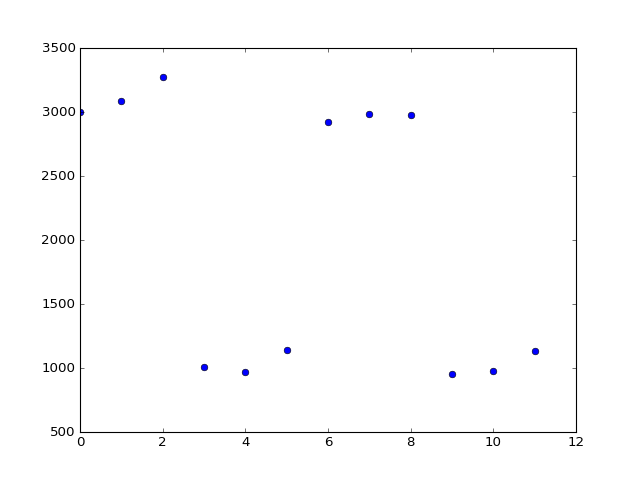

In [20]:
# Plot M0
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.plot(range(0,len(tubes)),[x[1][0]/rel_fa[x[0]] for x in enumerate(fits_t2)],'ob')

In [21]:
# Relative M0 ratios
np.mean(M0s[lf_tubes])/np.mean(M0s[hf_tubes])

0.336632624935993

In [22]:
# Relative M0 ratios based on model fit
As = np.asarray([x[1][0]/rel_fa[x[0]] for x in enumerate(fits_t2)])
np.mean(As[lf_tubes])/np.mean(As[hf_tubes])

0.33859771464455707

In [23]:
#SSFP Data, get M0 based on relaxation
ssfp_imgs = d[SSFP_data[0]][20:]

ssfp_img_arr = imlist_to_pixel_array(ssfp_imgs)
ssfp_snr = np.mean(ssfp_img_arr,axis=0)/(np.std(ssfp_img_arr,axis=0)+np.finfo(np.double).eps)

SSFP_TE = ssfp_imgs[0].EchoTime
SSFP_TR = ssfp_imgs[0].EchoTime*2
SSFP_TR = ssfp_imgs[0].RepetitionTime/ssfp_imgs[0].NumberOfPhaseEncodingSteps
SSFP_alpha = 2*np.pi*(ssfp_imgs[0].FlipAngle/360.0)
ssfp_signal = get_label_mean(ssfp_snr,labels,tubes)
E1 = np.exp(-SSFP_TR/T1s)
E2 = np.exp(-SSFP_TR/T2s)
alpha = SSFP_alpha*np.array(rel_fa)
ssfp_M0 = ssfp_signal / (np.sqrt(E2*(1-E1)*np.sin(alpha))/(1-(E1-E2)*np.cos(alpha)-E1*E2))
print(ssfp_M0)

[ 6.25899279  3.92838915  8.31578508  2.26462318  1.68658447  3.36012636
  6.80351476  4.61152778  9.09155703  2.43036525  1.75108848  3.35405686]


In [24]:
# M0 ratios from SSFP data
np.mean(ssfp_M0[lf_tubes])/np.mean(ssfp_M0[hf_tubes])

0.38059301277054558

In [25]:
# Actual signal ratios
ssfp_signal_adj = np.asarray(ssfp_signal)
np.mean(ssfp_signal_adj[lf_tubes])/np.mean(ssfp_signal_adj[hf_tubes])

0.48696851641655453

In [26]:
#GRE Data, get M0 based on relaxation parameters

gre_imgs = d[GRE_data[0]][20:]

gre_img_arr = imlist_to_pixel_array(gre_imgs)
gre_snr = np.mean(gre_img_arr,axis=0)/(np.std(gre_img_arr,axis=0)+np.finfo(np.double).eps)

GRE_TE = gre_imgs[0].EchoTime
GRE_TR = gre_imgs[0].RepetitionTime/gre_imgs[0].NumberOfPhaseEncodingSteps
GRE_alpha = 2*np.pi*(gre_imgs[0].FlipAngle/360.0)
gre_signal = get_label_mean(gre_snr,labels,tubes)
alpha = GRE_alpha*np.array(rel_fa)
gre_M0 = gre_signal / ((np.exp(-GRE_TE/T2stars)*np.sin(alpha)*(1-np.exp(-GRE_TR/T1s)))/(1-np.cos(alpha)*(np.exp(-GRE_TR/T1s))))
print(gre_M0)

[ 216.95002867  238.73123417  166.6715253    77.46392033   97.98997861
   65.77859781  252.39135409  275.85114081  175.17304054   86.31073185
   98.45747372   66.70960989]


In [27]:
# M0 ratios from GRE data
np.mean(gre_M0[lf_tubes])/np.mean(gre_M0[hf_tubes])

0.37164133691569956

In [28]:
# Actual signal ratios in GRE data
gre_signal_adj = np.asarray(gre_signal)
np.mean(gre_signal_adj[lf_tubes])/np.mean(gre_signal_adj[hf_tubes])

0.42970995424692726